# Anime Ratings Predictor
Building a regression workflow to forecast `average_rating` from metadata, with EDA, feature engineering, and model comparisons.

In [140]:
import warnings
from pathlib import Path
from typing import Dict, List

import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor

sns.set_theme(style="whitegrid", context="notebook")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [108]:
data_path = Path("Animes.csv")
assert data_path.exists(), f"Dataset not found at {data_path.resolve()}"
anime_df = pd.read_csv(data_path)
print(f"Loaded {anime_df.shape[0]} rows and {anime_df.shape[1]} columns")
anime_df.head()

Loaded 12194 rows and 18 columns


,anime_id,genres,name,average_rating,overview,type,episodes,producers,licensors,studios,source,anime_rating,rank,popularity,favorites,scored by,members,image url
0,32281,"Drama, Romance, School, Supernatural",Kimi no Na wa.,8.85,"Mitsuha Miyamizu, a high school girl, yearns t...",Movie,1,"Toho, Sound Team Don Juan, Amuse, JR East Mark...","Funimation, NYAV Post",CoMix Wave Films,Original,PG-13 - Teens 13 or older,27,11,87268,1807089,2597495,https://cdn.myanimelist.net/images/anime/5/870...
1,5114,"Action, Adventure, Drama, Fantasy, Magic, Mili...",Fullmetal Alchemist: Brotherhood,9.1,After a horrific alchemy experiment goes wrong...,TV,64,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,R - 17+ (violence & profanity),1,3,217606,2020030,3176556,https://cdn.myanimelist.net/images/anime/1208/...
2,28977,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama°,9.06,"Gintoki, Shinpachi, and Kagura return as the f...",TV,51,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,4,331,15947,237957,595767,https://cdn.myanimelist.net/images/anime/3/720...
3,9253,"Sci-Fi, Thriller",Steins;Gate,9.07,Eccentric scientist Rintarou Okabe has a never...,TV,24,"Frontier Works, Media Factory, Kadokawa Shoten...",Funimation,White Fox,Visual novel,PG-13 - Teens 13 or older,3,13,182964,1336233,2440369,https://cdn.myanimelist.net/images/anime/1935/...
4,9969,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama',9.04,"After a one-year hiatus, Shinpachi Shimura ret...",TV,51,"TV Tokyo, Aniplex, Dentsu, Trinity Sound, Mira...",UNKNOWN,Sunrise,Manga,PG-13 - Teens 13 or older,8,386,7765,226175,525688,https://cdn.myanimelist.net/images/anime/4/503...


## Exploratory Data Analysis
Understand structure, missingness, and relationships before modeling.

In [55]:
anime_df.sample(5, random_state=42)

,anime_id,genres,name,average_rating,overview,type,episodes,producers,licensors,studios,source,anime_rating,rank,popularity,favorites,scored by,members,image url
5700,8042,"School, Sports",Taishou Yakyuu Musume. Specials,6.1,The members of Ohka-kai heard of a rumor of an...,Special,2,UNKNOWN,UNKNOWN,J.C.Staff,Light novel,PG-13 - Teens 13 or older,8355,11278,1,423,1601,https://cdn.myanimelist.net/images/anime/10/19...
11022,2238,"Drama, Historical, Romance, Samurai, Yaoi",Fuyu no Semi,7.46,If time did not allow ordinary things to be or...,OVA,3,On-Lead,"Media Blasters, Kitty Media",Venet,Manga,R - 17+ (violence & profanity),UNKNOWN,4480,148,10205,20875,https://cdn.myanimelist.net/images/anime/1/244...
6062,24127,"Historical, Horror, Supernatural",Hashi no Mukou,5.76,There are old stories of children disappearing...,ONA,1,UNKNOWN,UNKNOWN,Iyasakadou Film,Unknown,R - 17+ (violence & profanity),9833,10860,1,836,1889,https://cdn.myanimelist.net/images/anime/12/62...
2221,31737,"Comedy, Ecchi, Fantasy, Harem, Romance, School...",Gakusen Toshi Asterisk 2nd Season,7,Gakusen Toshi Asterisk 2nd Season continues th...,TV,12,"Aniplex, Animax, Movic, flying DOG, Bandai Nam...",Aniplex of America,A-1 Pictures,Light novel,PG-13 - Teens 13 or older,4011,505,760,247507,421051,https://cdn.myanimelist.net/images/anime/11/79...
429,1089,"Action, Mecha, Military, Music, Romance, Sci-F...",Macross: Do You Remember Love?,7.94,"After warping light-years away from Earth, the...",Movie,1,"Mainichi Broadcasting System, Studio Nue, Big ...",UNKNOWN,Tatsunoko Production,Original,R+ - Mild Nudity,665,3036,717,21822,45884,https://cdn.myanimelist.net/images/anime/1080/...


In [56]:
print("DataFrame info:")
print(anime_df.info())
numeric_summary = anime_df.select_dtypes(include=[np.number]).describe().T
numeric_summary[['mean', 'std', 'min', 'max']]

DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12194 entries, 0 to 12193
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   anime_id        12194 non-null  int64 
 1   genres          12133 non-null  object
 2   name            12194 non-null  object
 3   average_rating  12194 non-null  object
 4   overview        12194 non-null  object
 5   type            12194 non-null  object
 6   episodes        12194 non-null  object
 7   producers       12194 non-null  object
 8   licensors       12194 non-null  object
 9   studios         12194 non-null  object
 10  source          12194 non-null  object
 11  anime_rating    12194 non-null  object
 12  rank            12194 non-null  object
 13  popularity      12194 non-null  int64 
 14  favorites       12194 non-null  int64 
 15  scored by       12194 non-null  object
 16  members         12194 non-null  int64 
 17  image url       12194 non-null  ob

,mean,std,min,max
anime_id,14000.555519,11437.671925,1.0,34527.0
popularity,8881.363703,5211.461624,1.0,19844.0
favorites,641.423651,5821.440456,0.0,217606.0
members,52191.128998,191364.187082,142.0,3744541.0


In [57]:
missing_summary = anime_df.isna().sum().sort_values(ascending=False)
missing_df = (missing_summary[missing_summary > 0] / len(anime_df) * 100).round(2).to_frame(name="missing_pct")
missing_df.head(15)

,missing_pct
genres,0.5


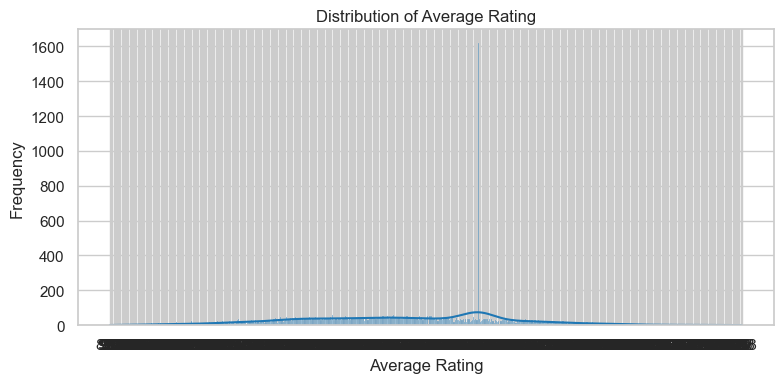

In [58]:
plt.figure(figsize=(8, 4))
sns.histplot(anime_df['average_rating'], bins=30, kde=True, color="#1f77b4")
plt.title("Distribution of Average Rating")
plt.xlabel("Average Rating")
plt.ylabel("Frequency")
plt.tight_layout()

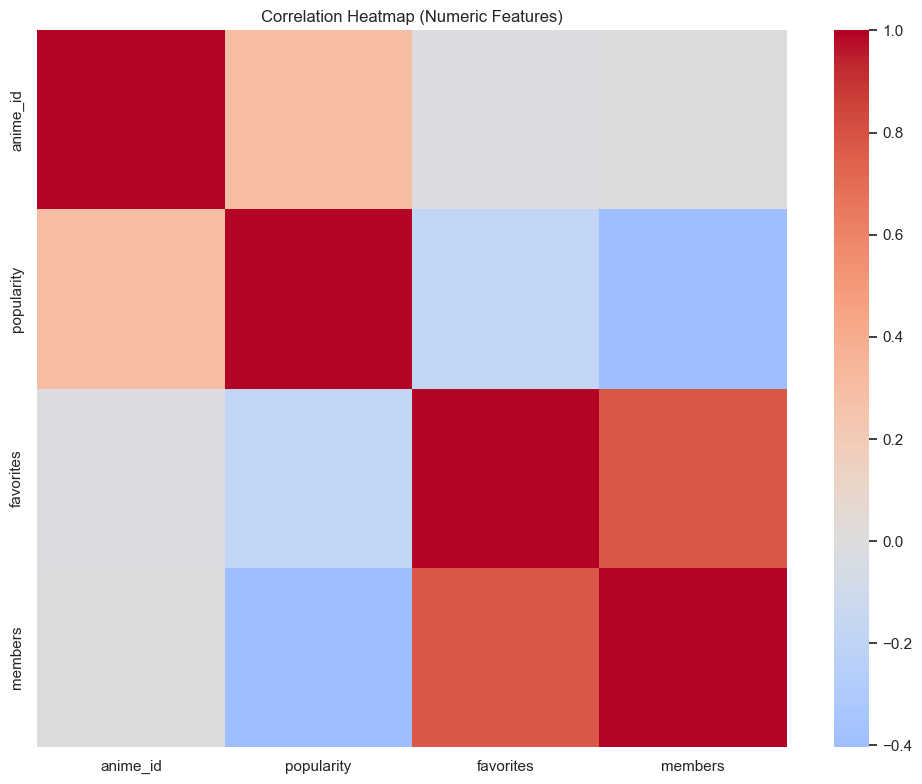

In [59]:
numeric_cols = anime_df.select_dtypes(include=[np.number]).columns.tolist()
corr_matrix = anime_df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()

## Feature Engineering & Data Preparation
Clean columns, engineer text features, and set up train/test splits while avoiding data leakage.

In [109]:
def standardize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    renamed = df.copy()
    renamed.columns = (
        renamed.columns
        .str.strip()
        .str.lower()
        .str.replace('[^0-9a-zA-Z]+', '_', regex=True)
        .str.strip('_')
    )
    return renamed


def coerce_numeric(df: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    updated = df.copy()
    for col in columns:
        if col in updated.columns:
            updated[col] = (
                updated[col]
                .replace({'Unknown': np.nan, 'unknown': np.nan, 'N/A': np.nan, 'UNKNOWN': np.nan})
                .astype(str)
            )
            updated[col] = pd.to_numeric(updated[col], errors='coerce')
    return updated


def count_from_comma_separated(series: pd.Series) -> pd.Series:
    return series.fillna('').astype(str).apply(
        lambda text: sum(1 for token in text.split(',') if token.strip())
    )


clean_df = standardize_column_names(anime_df).drop_duplicates(subset=['anime_id'])
numeric_candidates = ['anime_id', 'average_rating', 'episodes', 'rank', 'popularity', 'favorites', 'scored_by', 'members']
clean_df = coerce_numeric(clean_df, numeric_candidates)

feature_df = clean_df.copy()
feature_df['genre_count'] = count_from_comma_separated(feature_df['genres']) if 'genres' in feature_df else 0
feature_df['producer_count'] = count_from_comma_separated(feature_df['producers']) if 'producers' in feature_df else 0
feature_df['studio_count'] = count_from_comma_separated(feature_df['studios']) if 'studios' in feature_df else 0
feature_df['licensor_count'] = count_from_comma_separated(feature_df['licensors']) if 'licensors' in feature_df else 0
feature_df['overview_char_len'] = feature_df.get('overview', pd.Series(dtype=str)).fillna('').astype(str).str.len()
feature_df['overview_word_len'] = feature_df.get('overview', pd.Series(dtype=str)).fillna('').astype(str).str.split().str.len()
feature_df['has_licensor'] = (feature_df.get('licensors', pd.Series(dtype=str)).fillna('').str.strip() != '').astype(int)
feature_df['episodes_missing'] = feature_df['episodes'].isna().astype(int)

target_col = 'average_rating'
leakage_columns = ['image_url', 'rank']
feature_df = feature_df.drop(columns=[col for col in leakage_columns if col in feature_df.columns], errors='ignore')
feature_df = feature_df.drop(columns=['name'], errors='ignore')

for col in ['popularity', 'favorites', 'scored_by', 'members']:
    if col in clean_df.columns:
        feature_df[col] = clean_df[col]

for col in ['popularity', 'favorites', 'scored_by', 'members']:
    if col in feature_df.columns:
        feature_df[f'log_{col}'] = np.log1p(feature_df[col])

feature_df['log_episodes'] = np.log1p(feature_df['episodes'].fillna(0))
episode_safe = feature_df['episodes'].replace({0: np.nan})
member_safe = feature_df['members'].replace({0: np.nan}) if 'members' in feature_df else pd.Series(np.nan, index=feature_df.index)
favorite_safe = feature_df['favorites'].replace({0: np.nan}) if 'favorites' in feature_df else pd.Series(np.nan, index=feature_df.index)

feature_df['members_per_episode'] = (feature_df['members'] / episode_safe).replace([np.inf, -np.inf], np.nan).fillna(0) if 'members' in feature_df else 0
feature_df['favorites_per_episode'] = (feature_df['favorites'] / episode_safe).replace([np.inf, -np.inf], np.nan).fillna(0) if 'favorites' in feature_df else 0
feature_df['favorites_per_member'] = (feature_df['favorites'] / member_safe).replace([np.inf, -np.inf], np.nan).fillna(0) if 'favorites' in feature_df else 0
feature_df['scored_by_per_member'] = (feature_df['scored_by'] / member_safe).replace([np.inf, -np.inf], np.nan).fillna(0) if 'scored_by' in feature_df else 0
feature_df['is_long_series'] = (feature_df['episodes'].fillna(0) >= 50).astype(int)
feature_df = feature_df.drop(columns=['anime_id'], errors='ignore')
print(f"Post-cleaning shape: {feature_df.shape}")
feature_df.head(3)

Post-cleaning shape: (12194, 32)


,genres,average_rating,overview,type,episodes,producers,licensors,studios,source,anime_rating,popularity,favorites,scored_by,members,genre_count,producer_count,studio_count,licensor_count,overview_char_len,overview_word_len,has_licensor,episodes_missing,log_popularity,log_favorites,log_scored_by,log_members,log_episodes,members_per_episode,favorites_per_episode,favorites_per_member,scored_by_per_member,is_long_series
0,"Drama, Romance, School, Supernatural",8.85,"Mitsuha Miyamizu, a high school girl, yearns t...",Movie,1.0,"Toho, Sound Team Don Juan, Amuse, JR East Mark...","Funimation, NYAV Post",CoMix Wave Films,Original,PG-13 - Teens 13 or older,11,87268,1807089.0,2597495,4,6,1,2,823,144,1,0,2.484907,11.376751,14.407228,14.770058,0.693147,2.597495e+06,87268.000000,0.033597,0.695705,0
1,"Action, Adventure, Drama, Fantasy, Magic, Mili...",9.10,After a horrific alchemy experiment goes wrong...,TV,64.0,"Aniplex, Square Enix, Mainichi Broadcasting Sy...","Funimation, Aniplex of America",Bones,Manga,R - 17+ (violence & profanity),3,217606,2020030.0,3176556,7,4,1,2,1137,177,1,0,1.386294,12.290446,14.518623,14.971308,4.174387,4.963369e+04,3400.093750,0.068504,0.635918,1
2,"Action, Comedy, Historical, Parody, Samurai, S...",9.06,"Gintoki, Shinpachi, and Kagura return as the f...",TV,51.0,"TV Tokyo, Aniplex, Dentsu","Funimation, Crunchyroll",Bandai Namco Pictures,Manga,PG-13 - Teens 13 or older,331,15947,237957.0,595767,7,3,1,2,1173,185,1,0,5.805135,9.677089,12.379849,13.297607,3.951244,1.168171e+04,312.686275,0.026767,0.399413,1


In [110]:
model_df = feature_df.dropna(subset=[target_col]).reset_index(drop=True)
y = model_df[target_col]
X = model_df.drop(columns=[target_col])

categorical_features = [col for col in ['type', 'source', 'anime_rating'] if col in X.columns]
text_features = [col for col in ['overview', 'genres', 'producers', 'licensors', 'studios'] if col in X.columns]
numeric_features = [col for col in X.select_dtypes(include=[np.number]).columns if col not in categorical_features]

print(
    f"Using {len(X)} observations, {len(numeric_features)} numeric, {len(categorical_features)} categorical, and {len(text_features)} text features"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Using 10577 observations, 23 numeric, 3 categorical, and 5 text features


In [111]:
def make_text_array(values):
    if isinstance(values, pd.DataFrame):
        series = values.iloc[:, 0]
    else:
        series = pd.Series(values)
    return series.fillna('').astype(str).values


def comma_tokenizer(text: str) -> List[str]:
    return [token.strip().lower() for token in text.split(',') if token and token.strip()]


class DenseTruncatedSVD(BaseEstimator, TransformerMixin):
    def __init__(self, n_components: int = 50, random_state: int = 42):
        self.n_components = n_components
        self.random_state = random_state
        self._svd = None
        self.actual_components_ = 0
        self._use_identity = False

    def fit(self, X, y=None):
        n_features = X.shape[1]
        if n_features <= 1:
            self.actual_components_ = n_features
            self._svd = None
            self._use_identity = True
            return self
        self._use_identity = False
        self.actual_components_ = min(self.n_components, n_features - 1)
        self._svd = TruncatedSVD(n_components=self.actual_components_, random_state=self.random_state)
        self._svd.fit(X)
        return self

    def transform(self, X):
        if self._use_identity:
            return X.toarray() if hasattr(X, 'toarray') else np.asarray(X)
        if self._svd is None or self.actual_components_ == 0:
            return np.zeros((X.shape[0], 0))
        return self._svd.transform(X)

In [115]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

text_transformers = []
if 'overview' in text_features:
    text_transformers.append((
        'overview',
        Pipeline([
            ('to_str', FunctionTransformer(make_text_array, validate=False)),
            ('tfidf', TfidfVectorizer(
                max_features=800,
                ngram_range=(1, 2),
                min_df=5,
                stop_words='english'
            )),
            ('svd', DenseTruncatedSVD(n_components=40, random_state=42))
        ]),
        'overview'
    ))
if 'genres' in text_features:
    text_transformers.append((
        'genres',
        Pipeline([
            ('to_str', FunctionTransformer(make_text_array, validate=False)),
            ('tfidf', TfidfVectorizer(
                max_features=80,
                tokenizer=comma_tokenizer,
                lowercase=True
            )),
            ('svd', DenseTruncatedSVD(n_components=20, random_state=42))
        ]),
        'genres'
    ))
for col in ['producers', 'licensors', 'studios']:
    if col in text_features:
        text_transformers.append((
            col,
            Pipeline([
                ('to_str', FunctionTransformer(make_text_array, validate=False)),
                ('tfidf', TfidfVectorizer(
                    max_features=60,
                    tokenizer=comma_tokenizer,
                    lowercase=True
                )),
                ('svd', DenseTruncatedSVD(n_components=20, random_state=42))
            ]),
            col
        ))

full_transformers = []
if numeric_features:
    full_transformers.append(('num', numeric_transformer, numeric_features))
if categorical_features:
    full_transformers.append(('cat', categorical_transformer, categorical_features))
full_transformers.extend(text_transformers)

preprocessor = ColumnTransformer(
    transformers=full_transformers,
    remainder='drop',
    sparse_threshold=0.0
)

simple_numeric_features = [col for col in numeric_features if col not in ['anime_id']]
if not simple_numeric_features:
    simple_numeric_features = numeric_features

simple_preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, simple_numeric_features)],
    remainder='drop',
    sparse_threshold=0.0
)

poly_exclude = {
    'popularity', 'favorites', 'scored_by', 'members',
    'log_popularity', 'log_favorites', 'log_scored_by', 'log_members',
    'members_per_episode', 'favorites_per_episode', 'favorites_per_member', 'scored_by_per_member'
}
poly_numeric_features = [col for col in simple_numeric_features if col not in poly_exclude]
if not poly_numeric_features:
    poly_numeric_features = simple_numeric_features

poly_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('pre_scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False, degree=2)),
    ('post_scaler', StandardScaler())
])

poly_transformers = [('num_poly', poly_transformer, poly_numeric_features)]
if categorical_features:
    poly_transformers.append(('cat', categorical_transformer, categorical_features))

poly_preprocessor = ColumnTransformer(
    transformers=poly_transformers,
    remainder='drop',
    sparse_threshold=0.0
)

## Model Training & Evaluation
Compare multiple regressors with stratified cross-validation and GridSearch-based tuning.

In [74]:
np.random.seed(42)
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

In [116]:
model_configs = [
    {
        'name': 'Linear Regression (Simple Numeric)',
        'pipeline': Pipeline([
            ('preprocess', simple_preprocessor),
            ('model', LinearRegression())
        ]),
        'param_grid': {
            'model__fit_intercept': [True, False]
        }
    },
    {
        'name': 'Linear Regression (Full Features)',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('feature_scaler', StandardScaler()),
            ('model', LinearRegression())
        ]),
        'param_grid': {
            'model__fit_intercept': [True, False]
        }
    },
    {
        'name': 'Polynomial Regression',
        'pipeline': Pipeline([
            ('preprocess', poly_preprocessor),
            ('model', LinearRegression())
        ]),
        'param_grid': {
            'preprocess__num_poly__poly__degree': [2],
            'model__fit_intercept': [True, False]
        }
    },
    {
        'name': 'Lasso Regression (L1)',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('feature_scaler', StandardScaler()),
            ('model', Lasso(max_iter=4000, random_state=42))
        ]),
        'param_grid': {
            'model__alpha': [0.001, 0.01, 0.1, 1.0]
        }
    },
    {
        'name': 'Ridge Regression (L2)',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('feature_scaler', StandardScaler()),
            ('model', Ridge())
        ]),
        'param_grid': {
            'model__alpha': [0.1, 1.0, 10.0]
        }
    },
    {
        'name': 'Elastic Net',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('feature_scaler', StandardScaler()),
            ('model', ElasticNet(max_iter=4000, random_state=42))
        ]),
        'param_grid': {
            'model__alpha': [0.001, 0.01, 0.1, 1.0],
            'model__l1_ratio': [0.2, 0.5, 0.8]
        }
    },
    {
        'name': 'Random Forest Regressor',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
        ]),
        'param_grid': {
            'model__n_estimators': [150, 250],
            'model__max_depth': [8, 12],
            'model__min_samples_leaf': [2, 5]
        }
    },
    {
        'name': 'Gradient Boosting Regressor',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('model', GradientBoostingRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__learning_rate': [0.05, 0.1],
            'model__n_estimators': [200, 300],
            'model__max_depth': [2, 3],
            'model__subsample': [0.8, 1.0]
        }
    },
    {
        'name': 'HistGradient Boosting Regressor',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('model', HistGradientBoostingRegressor(random_state=42))
        ]),
        'param_grid': {
            'model__learning_rate': [0.05, 0.08, 0.1],
            'model__max_depth': [None, 8, 12],
            'model__l2_regularization': [0.0, 0.1, 0.5]
        }
    },
    {
        'name': 'XGBoost Regressor',
        'pipeline': Pipeline([
            ('preprocess', preprocessor),
            ('model', XGBRegressor(
                objective='reg:squarederror',
                eval_metric='rmse',
                random_state=42,
                tree_method='hist',
                n_jobs=-1
            ))
        ]),
        'param_grid': {
            'model__n_estimators': [300, 450],
            'model__max_depth': [4, 5],
            'model__learning_rate': [0.05, 0.08],
            'model__subsample': [0.85, 1.0],
            'model__colsample_bytree': [0.7, 0.9],
            'model__min_child_weight': [1, 3]
        }
    }
]

In [117]:
results_df, best_estimators = evaluate_regressors(model_configs)
results_df

Training Linear Regression (Simple Numeric) ...
Training Linear Regression (Full Features) ...
Training Polynomial Regression ...
Training Lasso Regression (L1) ...
Training Ridge Regression (L2) ...
Training Elastic Net ...
Training Random Forest Regressor ...
Training Gradient Boosting Regressor ...
Training HistGradient Boosting Regressor ...
Training XGBoost Regressor ...


,model,best_params,cv_r2_mean,cv_r2_std,test_r2,test_mae,test_rmse
0,XGBoost Regressor,"{'model__colsample_bytree': 0.9, 'model__learn...",0.786149,0.006608,0.805800,0.309279,0.415883
1,HistGradient Boosting Regressor,"{'model__l2_regularization': 0.0, 'model__lear...",0.779611,0.006526,0.794596,0.319966,0.427712
2,Gradient Boosting Regressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.771966,0.005233,0.787857,0.325895,0.434672
3,Random Forest Regressor,"{'model__max_depth': 12, 'model__min_samples_l...",0.755209,0.008333,0.767885,0.334428,0.454672
4,Ridge Regression (L2),{'model__alpha': 0.1},0.725951,0.005430,0.742770,0.365052,0.478638
5,Linear Regression (Full Features),{'model__fit_intercept': True},0.725936,0.005477,0.742720,0.365138,0.478685
6,Elastic Net,"{'model__alpha': 0.001, 'model__l1_ratio': 0.2}",0.724774,0.005538,0.741988,0.365167,0.479366
7,Lasso Regression (L1),{'model__alpha': 0.001},0.723587,0.005925,0.741204,0.365386,0.480094
8,Linear Regression (Simple Numeric),{'model__fit_intercept': True},0.613338,0.014671,0.646405,0.430030,0.561177
9,Polynomial Regression,"{'model__fit_intercept': True, 'preprocess__nu...",0.318362,0.084161,0.499912,0.524812,0.667375


## Model Comparison
Aggregated metrics to benchmark performance across tuned regressors.

In [118]:
comparison_df = results_df.copy()
metric_cols = ['cv_r2_mean', 'cv_r2_std', 'test_r2', 'test_mae', 'test_rmse']
comparison_df[metric_cols] = comparison_df[metric_cols].applymap(lambda x: round(x, 4))
comparison_df

,model,best_params,cv_r2_mean,cv_r2_std,test_r2,test_mae,test_rmse
0,XGBoost Regressor,"{'model__colsample_bytree': 0.9, 'model__learn...",0.7861,0.0066,0.8058,0.3093,0.4159
1,HistGradient Boosting Regressor,"{'model__l2_regularization': 0.0, 'model__lear...",0.7796,0.0065,0.7946,0.3200,0.4277
2,Gradient Boosting Regressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.7720,0.0052,0.7879,0.3259,0.4347
3,Random Forest Regressor,"{'model__max_depth': 12, 'model__min_samples_l...",0.7552,0.0083,0.7679,0.3344,0.4547
4,Ridge Regression (L2),{'model__alpha': 0.1},0.7260,0.0054,0.7428,0.3651,0.4786
5,Linear Regression (Full Features),{'model__fit_intercept': True},0.7259,0.0055,0.7427,0.3651,0.4787
6,Elastic Net,"{'model__alpha': 0.001, 'model__l1_ratio': 0.2}",0.7248,0.0055,0.7420,0.3652,0.4794
7,Lasso Regression (L1),{'model__alpha': 0.001},0.7236,0.0059,0.7412,0.3654,0.4801
8,Linear Regression (Simple Numeric),{'model__fit_intercept': True},0.6133,0.0147,0.6464,0.4300,0.5612
9,Polynomial Regression,"{'model__fit_intercept': True, 'preprocess__nu...",0.3184,0.0842,0.4999,0.5248,0.6674


In [119]:
metrics_view = comparison_df[['model', 'cv_r2_mean', 'cv_r2_std', 'test_r2', 'test_mae', 'test_rmse']]
metrics_view.sort_values('test_r2', ascending=False).reset_index(drop=True)

,model,cv_r2_mean,cv_r2_std,test_r2,test_mae,test_rmse
0,XGBoost Regressor,0.7861,0.0066,0.8058,0.3093,0.4159
1,HistGradient Boosting Regressor,0.7796,0.0065,0.7946,0.3200,0.4277
2,Gradient Boosting Regressor,0.7720,0.0052,0.7879,0.3259,0.4347
3,Random Forest Regressor,0.7552,0.0083,0.7679,0.3344,0.4547
4,Ridge Regression (L2),0.7260,0.0054,0.7428,0.3651,0.4786
5,Linear Regression (Full Features),0.7259,0.0055,0.7427,0.3651,0.4787
6,Elastic Net,0.7248,0.0055,0.7420,0.3652,0.4794
7,Lasso Regression (L1),0.7236,0.0059,0.7412,0.3654,0.4801
8,Linear Regression (Simple Numeric),0.6133,0.0147,0.6464,0.4300,0.5612
9,Polynomial Regression,0.3184,0.0842,0.4999,0.5248,0.6674


In [120]:
comparison_df.sort_values('test_r2', ascending=False).head(8)

,model,best_params,cv_r2_mean,cv_r2_std,test_r2,test_mae,test_rmse
0,XGBoost Regressor,"{'model__colsample_bytree': 0.9, 'model__learn...",0.7861,0.0066,0.8058,0.3093,0.4159
1,HistGradient Boosting Regressor,"{'model__l2_regularization': 0.0, 'model__lear...",0.7796,0.0065,0.7946,0.3200,0.4277
2,Gradient Boosting Regressor,"{'model__learning_rate': 0.1, 'model__max_dept...",0.7720,0.0052,0.7879,0.3259,0.4347
3,Random Forest Regressor,"{'model__max_depth': 12, 'model__min_samples_l...",0.7552,0.0083,0.7679,0.3344,0.4547
4,Ridge Regression (L2),{'model__alpha': 0.1},0.7260,0.0054,0.7428,0.3651,0.4786
5,Linear Regression (Full Features),{'model__fit_intercept': True},0.7259,0.0055,0.7427,0.3651,0.4787
6,Elastic Net,"{'model__alpha': 0.001, 'model__l1_ratio': 0.2}",0.7248,0.0055,0.7420,0.3652,0.4794
7,Lasso Regression (L1),{'model__alpha': 0.001},0.7236,0.0059,0.7412,0.3654,0.4801


In [121]:
list(best_estimators.keys())

['Linear Regression (Simple Numeric)',
 'Linear Regression (Full Features)',
 'Polynomial Regression',
 'Lasso Regression (L1)',
 'Ridge Regression (L2)',
 'Elastic Net',
 'Random Forest Regressor',
 'Gradient Boosting Regressor',
 'HistGradient Boosting Regressor',
 'XGBoost Regressor']

In [122]:
best_row = comparison_df.sort_values('test_r2', ascending=False).iloc[0]
best_model_name = best_row['model']
best_model = best_estimators[best_model_name]
best_model_name

'XGBoost Regressor'

In [123]:
best_model

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [124]:
best_model.named_steps.keys()

dict_keys(['preprocess', 'model'])

In [138]:
X.columns.tolist()

['genres',
 'overview',
 'type',
 'episodes',
 'producers',
 'licensors',
 'studios',
 'source',
 'anime_rating',
 'popularity',
 'favorites',
 'scored_by',
 'members',
 'genre_count',
 'producer_count',
 'studio_count',
 'licensor_count',
 'overview_char_len',
 'overview_word_len',
 'has_licensor',
 'episodes_missing',
 'log_popularity',
 'log_favorites',
 'log_scored_by',
 'log_members',
 'log_episodes',
 'members_per_episode',
 'favorites_per_episode',
 'favorites_per_member',
 'scored_by_per_member',
 'is_long_series']

## Visualization Assets for Streamlit
Enhance the deployment experience with ready-to-use diagnostic plots and model intelligence summaries.

In [132]:
from sklearn.inspection import permutation_importance
from datetime import datetime
import joblib
import json

best_predictions = best_model.predict(X_test)
residuals = y_test - best_predictions
mse = mean_squared_error(y_test, best_predictions)
rmse = float(np.sqrt(mse))
mae = float(mean_absolute_error(y_test, best_predictions))
r2 = float(r2_score(y_test, best_predictions))

perm_result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=42,
    n_jobs=-1
)
importance_df = (
    pd.DataFrame({
        'feature': X.columns,
        'importance_mean': perm_result.importances_mean,
        'importance_std': perm_result.importances_std
    })
    .sort_values('importance_mean', ascending=False)
    .reset_index(drop=True)
)
importance_df.head(10)

,feature,importance_mean,importance_std
0,favorites,0.175613,0.007241
1,genres,0.092144,0.004312
2,popularity,0.084997,0.002420
3,favorites_per_member,0.058690,0.002600
4,scored_by_per_member,0.045951,0.006305
5,studios,0.040807,0.003551
6,episodes,0.020527,0.001079
7,members,0.018977,0.001621
8,type,0.018976,0.001855
9,overview,0.015932,0.001732


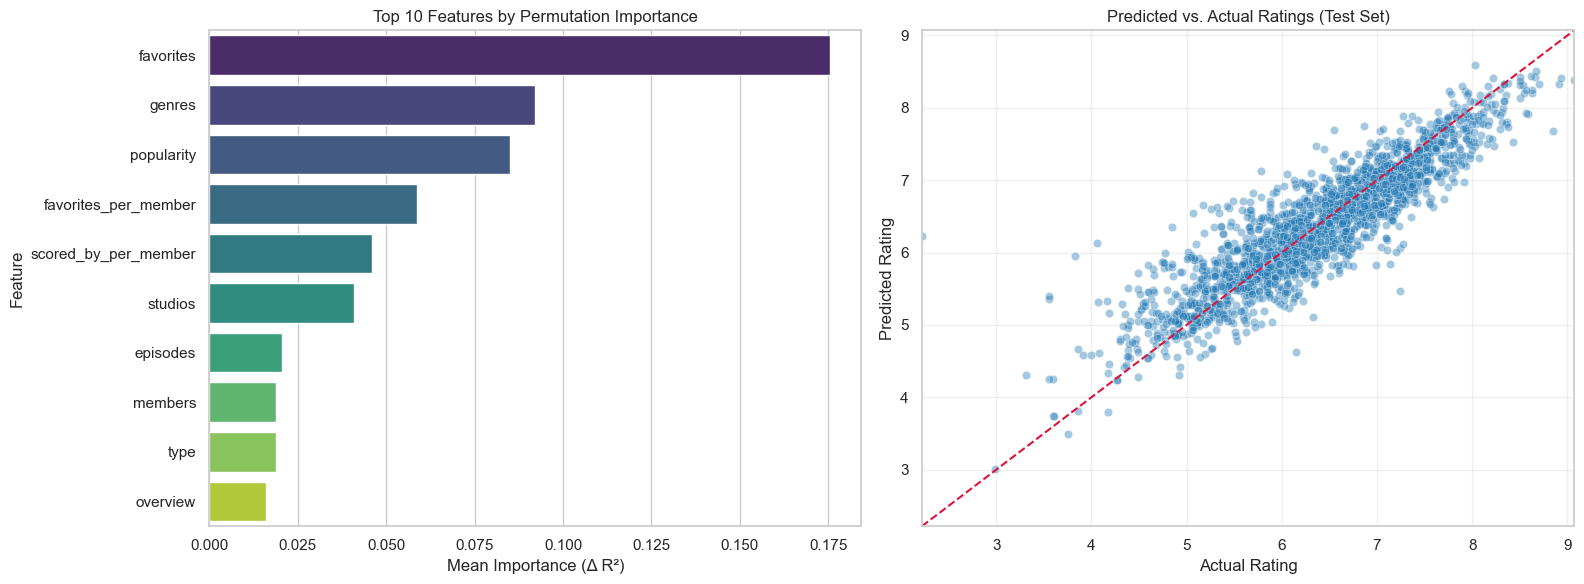

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Feature importance bar plot
imp_to_plot = importance_df.head(10)
sns.barplot(
    ax=axes[0],
    data=imp_to_plot,
    x='importance_mean',
    y='feature',
    palette='viridis'
)
axes[0].set_title('Top 10 Features by Permutation Importance')
axes[0].set_xlabel('Mean Importance (Δ R²)')
axes[0].set_ylabel('Feature')

# Actual vs predicted scatter plot
diag_min = min(y_test.min(), best_predictions.min())
diag_max = max(y_test.max(), best_predictions.max())
axes[1].scatter(y_test, best_predictions, alpha=0.4, color='#1f77b4', edgecolor='white', linewidth=0.5)
axes[1].plot([diag_min, diag_max], [diag_min, diag_max], color='crimson', linestyle='--', linewidth=1.5)
axes[1].set_title('Predicted vs. Actual Ratings (Test Set)')
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_xlim(diag_min, diag_max)
axes[1].set_ylim(diag_min, diag_max)
axes[1].grid(alpha=0.3)

plt.tight_layout()

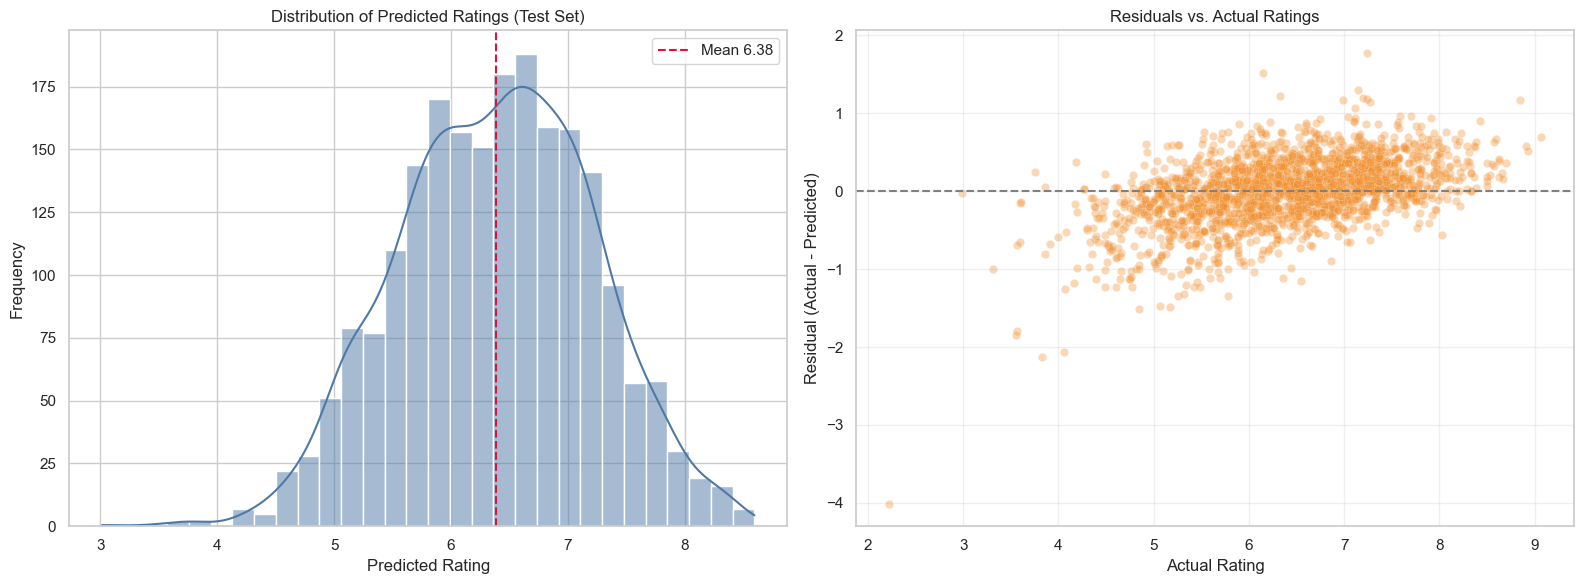

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(best_predictions, bins=30, kde=True, color='#4e79a7', ax=axes[0])
axes[0].axvline(best_predictions.mean(), color='crimson', linestyle='--', label=f"Mean {best_predictions.mean():.2f}")
axes[0].set_title('Distribution of Predicted Ratings (Test Set)')
axes[0].set_xlabel('Predicted Rating')
axes[0].set_ylabel('Frequency')
axes[0].legend()

sns.scatterplot(x=y_test, y=residuals, ax=axes[1], alpha=0.35, color='#f28e2b', edgecolor='white', linewidth=0.3)
axes[1].axhline(0, color='gray', linestyle='--')
axes[1].set_title('Residuals vs. Actual Ratings')
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Residual (Actual - Predicted)')
axes[1].grid(alpha=0.3)

plt.tight_layout()

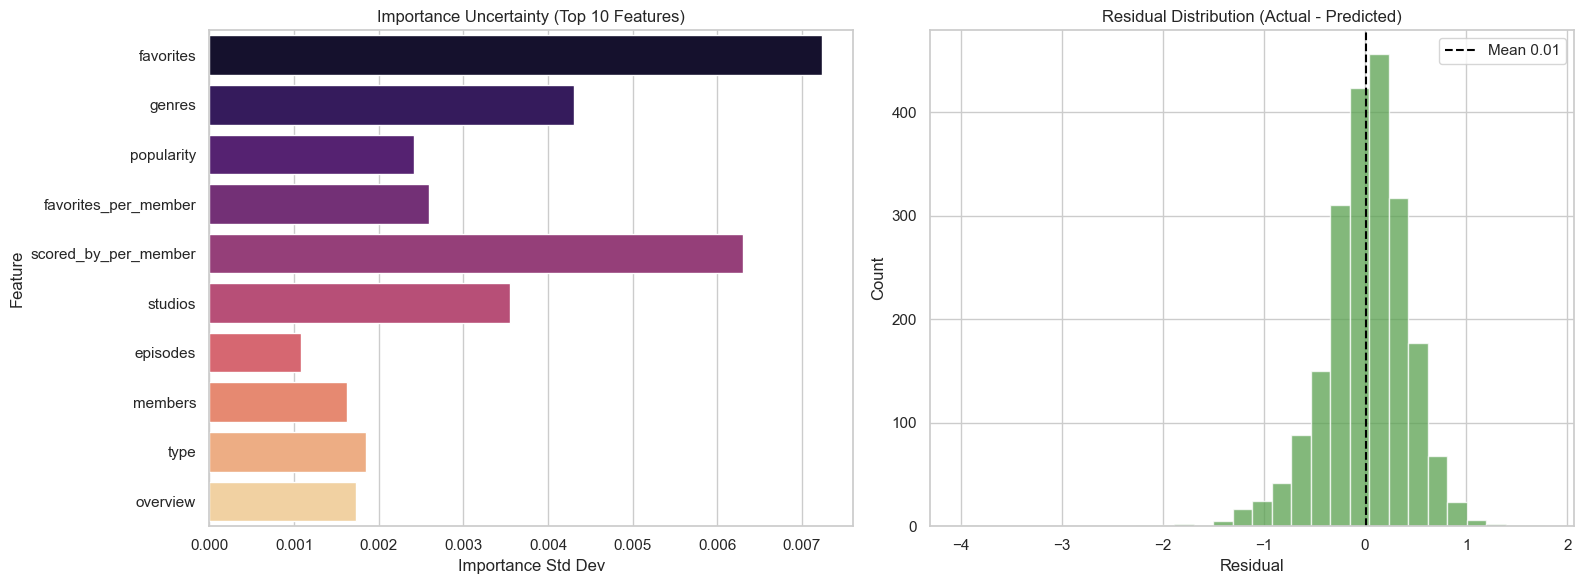

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(
    data=importance_df.head(10),
    x='importance_std',
    y='feature',
    palette='magma',
    ax=axes[0]
)
axes[0].set_title('Importance Uncertainty (Top 10 Features)')
axes[0].set_xlabel('Importance Std Dev')
axes[0].set_ylabel('Feature')

axes[1].hist(residuals, bins=30, color='#59a14f', alpha=0.75)
axes[1].axvline(residuals.mean(), color='black', linestyle='--', label=f"Mean {residuals.mean():.2f}")
axes[1].set_title('Residual Distribution (Actual - Predicted)')
axes[1].set_xlabel('Residual')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()

In [143]:
metrics_summary = pd.DataFrame({
    'metric': ['Model', 'CV R² (mean)', 'CV R² (std)', 'Test R²', 'RMSE', 'MAE'],
    'value': [
        best_model_name,
        round(float(best_row['cv_r2_mean']), 4),
        round(float(best_row['cv_r2_std']), 4),
        round(float(best_row['test_r2']), 4),
        round(rmse, 4),
        round(mae, 4)
    ]
})
metrics_summary

,metric,value
0,Model,XGBoost Regressor
1,CV R² (mean),0.7861
2,CV R² (std),0.0066
3,Test R²,0.8058
4,RMSE,0.4159
5,MAE,0.3093


In [144]:
artifact_dir = Path("artifacts")
artifact_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = artifact_dir / f"best_anime_rating_model_{timestamp}.joblib"
info_filename = artifact_dir / f"model_feature_info_{timestamp}.pkl"
metrics_filename = artifact_dir / f"model_metrics_{timestamp}.csv"

joblib.dump(best_model, model_filename)

summary_frame = pd.DataFrame({
    'metric': ['cv_r2_mean', 'cv_r2_std', 'test_r2', 'rmse', 'mae'],
    'value': [
        float(best_row['cv_r2_mean']),
        float(best_row['cv_r2_std']),
        float(best_row['test_r2']),
        rmse,
        mae
    ]
})
summary_frame.to_csv(metrics_filename, index=False)

minimal_columns = [
    col for col in [
        'members', 'favorites', 'episodes', 'genre_count', 'producer_count',
        'studio_count', 'licensor_count', 'members_per_episode',
        'favorites_per_episode', 'favorites_per_member', 'scored_by_per_member'
    ] if col in X_test.columns
]

eval_frame = pd.DataFrame({
    'actual': y_test,
    'predicted': best_predictions,
    'residual': residuals
})
if minimal_columns:
    eval_frame[minimal_columns] = X_test[minimal_columns]

category_options = {
    'type': sorted(X['type'].dropna().unique().tolist()) if 'type' in X.columns else [],
    'source': sorted(X['source'].dropna().unique().tolist()) if 'source' in X.columns else [],
    'anime_rating': sorted(X['anime_rating'].dropna().unique().tolist()) if 'anime_rating' in X.columns else []
}

feature_info = {
    'model_name': best_model_name,
    'timestamp': timestamp,
    'raw_feature_names': X.columns.tolist(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'text_features': text_features,
    'category_options': category_options,
    'data_info': {
        'total_samples': int(len(model_df)),
        'n_features': int(X.shape[1]),
        'target_mean': float(y.mean()),
        'target_std': float(y.std()),
        'train_samples': int(len(X_train)),
        'test_samples': int(len(X_test))
    },
    'model_performance': {
        'cv_r2_mean': float(best_row['cv_r2_mean']),
        'cv_r2_std': float(best_row['cv_r2_std']),
        'test_r2': float(best_row['test_r2']),
        'rmse': rmse,
        'mae': mae,
        'training_date': datetime.now().strftime("%Y-%m-%d")
    },
    'feature_importance': importance_df.to_dict(orient='records'),
    'top_features': importance_df.head(10).to_dict(orient='records'),
    'evaluation_frame': eval_frame,
    'metrics_summary': metrics_summary.to_dict(orient='records')
}

with open(info_filename, 'wb') as f:
    pickle.dump(feature_info, f)

model_filename, info_filename

(WindowsPath('artifacts/best_anime_rating_model_20251101_002054.joblib'),
 WindowsPath('artifacts/model_feature_info_20251101_002054.pkl'))